In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# import pyflux as pf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from arch import arch_model
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller


from data.stock_data import StockData


In [120]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()

# Drop all the rows where Log Return is exactly 0
sp500 = sp500[sp500['Log Return'] != 0]
sp500 = sp500.dropna()
sp500

# Make the sp500 be on a weekly frequency instead of daily
sp500 = sp500.resample('W').sum()
sp500.to_csv('data/sp500_weekly.csv')


[*********************100%***********************]  1 of 1 completed


In [121]:
# Import macro data
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
0,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
1,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
2,2006-03,4.515,0.338,0.006086,0.085002,3.362649,-0.020833
3,2006-04,4.650,0.419,-0.002866,0.078793,3.545735,0.000000
4,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667,-0.021277
...,...,...,...,...,...,...,...
206,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974,-0.027778
207,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320,-0.028571
208,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609,0.088235
209,2023-06,5.153,-1.334,0.004591,0.037450,2.969178,-0.027027


In [122]:
# Calculate the monthly RV for log returns
sp500['RV'] = sp500['Squared Return'].resample('M').sum()
# Backward fill the nans in RV
sp500['RV'] = sp500['RV'].fillna(method='bfill')
sp500 = sp500.dropna()
sp500.head()

,Log Return,Squared Return,RV
Date,,,
2006-01-08,1.303720,1.009653,7.069914
2006-01-15,0.167896,0.665918,7.069914
2006-01-22,-2.049422,4.014040,7.069914
2006-01-29,1.746854,1.239267,7.069914
2006-02-05,-1.545704,1.323481,7.069914


In [123]:
# Merge the hf stock data with lf macro data based on the month
sp500.index = pd.to_datetime(sp500.index)
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])
sp500['YearMonth'] = sp500.index.to_period('M')
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')
macro_df.drop('Year-Month', axis=1, inplace=True)
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')
merged_df.set_index('Date', inplace=True)

In [124]:
merged_df

,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
Date,,,,,,,,,,
2006-01-08,1.303720,1.009653,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-15,0.167896,0.665918,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-22,-2.049422,4.014040,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-29,1.746854,1.239267,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-02-05,-1.545704,1.323481,7.069914,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
...,...,...,...,...,...,...,...,...,...,...
2022-07-03,-2.233753,6.110621,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778
2022-07-10,1.917278,2.365505,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778
2022-07-17,-0.933206,6.113793,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778


### Create pricipal components from macro data

In [125]:
# Features list should include everything else than Log Return	Squared Return	RV	YearMonth
# Get all column names from merged_df
all_cols = merged_df.columns.tolist()

# Define the columns to exclude from features list
exclude_cols = ['Log Return', 'Squared Return', 'RV', 'YearMonth']

# Create the features list
features = [col for col in all_cols if col not in exclude_cols]

# Print the features list
display(features)

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x

['3 Month T-Bill Rate',
 'Yield Curve Slope',
 'Reer Change',
 'Change Oil Price',
 'CPI',
 'Unemployment Rate Change']

array([[ 2.26878322, -1.41572194, -0.81082609,  0.84208742,  0.89765513,
        -0.27237482],
       [ 2.26878322, -1.41572194, -0.81082609,  0.84208742,  0.89765513,
        -0.27237482],
       [ 2.26878322, -1.41572194, -0.81082609,  0.84208742,  0.89765513,
        -0.27237482],
       ...,
       [ 0.86862747, -1.23410142,  1.26440954, -0.63730315,  3.31430316,
        -0.19314725],
       [ 0.86862747, -1.23410142,  1.26440954, -0.63730315,  3.31430316,
        -0.19314725],
       [ 0.86862747, -1.23410142,  1.26440954, -0.63730315,  3.31430316,
        -0.19314725]])

In [126]:
# Create principal components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [127]:
merged_df = (merged_df.reset_index()
                      .join(principalDf, how='right')
                      .set_index('Date'))

merged_df

,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change,principal component 1,principal component 2
Date,,,,,,,,,,,,
2006-01-08,1.303720,1.009653,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.940635,-0.599226
2006-01-15,0.167896,0.665918,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.940635,-0.599226
2006-01-22,-2.049422,4.014040,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.940635,-0.599226
2006-01-29,1.746854,1.239267,7.069914,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816,2.940635,-0.599226
2006-02-05,-1.545704,1.323481,7.069914,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277,2.668812,1.080976
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-03,-2.233753,6.110621,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778,2.119815,2.351402
2022-07-10,1.917278,2.365505,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778,2.119815,2.351402
2022-07-17,-0.933206,6.113793,36.387359,2022-07,2.298,0.344,0.016570,-0.067511,8.524815,-0.027778,2.119815,2.351402


In [128]:
sp500_returns = sp500[['Log Return', 'Squared Return']]
sp500_returns

,Log Return,Squared Return
0,1.303720,1.009653
1,0.167896,0.665918
2,-2.049422,4.014040
3,1.746854,1.239267
4,-1.545704,1.323481
...,...,...
860,-2.233753,6.110621
861,1.917278,2.365505
862,-0.933206,6.113793
863,2.517005,10.320608


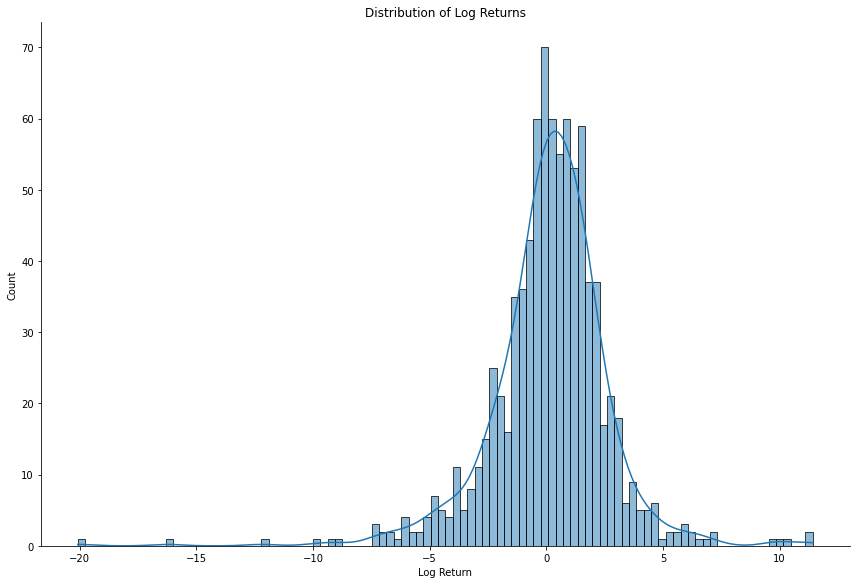

count    865.000000
mean       0.136448
std        2.547188
min      -20.083751
25%       -0.968581
50%        0.272503
75%        1.459350
max       11.423675
Name: Log Return, dtype: float64
Skewness (Log Returns):  -1.0053881774891373
Kurtosis (Log Returns):  8.733371492612612


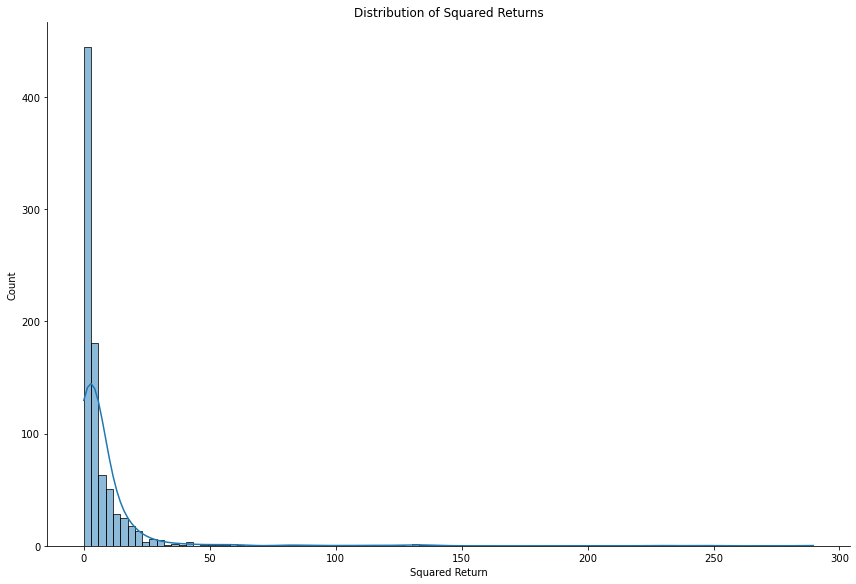

count    865.000000
mean       7.743746
std       20.580602
min        0.033871
25%        1.078396
50%        2.849271
75%        6.653569
max      289.535432
Name: Squared Return, dtype: float64
Skewness (Squared Returns):  8.1626544612786
Kurtosis (Squared Returns):  84.08412882175287


In [129]:
"""
# Descriptive statistics for daily returns
print(sp500['Daily Return'].describe())

# Plotting the distribution of daily returns
sns.displot(sp500['Daily Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Daily Returns')
plt.show()

# Skewness and kurtosis for daily returns
print('Skewness (Daily Returns): ', skew(sp500['Daily Return'].dropna()))
print('Kurtosis (Daily Returns): ', kurtosis(sp500['Daily Return'].dropna()))
"""

# Plotting the distribution of log returns
sns.displot(sp500['Log Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Log Returns')
plt.show()

# Descriptive statistics for log returns
print(sp500['Log Return'].describe())

# Skewness and kurtosis for log returns
print('Skewness (Log Returns): ', skew(sp500['Log Return'].dropna()))
print('Kurtosis (Log Returns): ', kurtosis(sp500['Log Return'].dropna()))

# Plotting the distribution of squared returns
sns.displot(sp500['Squared Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Squared Returns')
plt.show()

# Descriptive statistics for squared returns
print(sp500['Squared Return'].describe())

# Skewness and kurtosis for squared returns
print('Skewness (Squared Returns): ', skew(sp500['Squared Return'].dropna()))
print('Kurtosis (Squared Returns): ', kurtosis(sp500['Squared Return'].dropna()))


In [130]:
# Find the date of highest squared return in sp500
sp500.sort_values(ascending=False, by='Squared Return')


,Date,Log Return,Squared Return,RV,YearMonth
740,2020-03-15,-9.203470,289.535432,50.753754,2020-03
741,2020-03-22,-16.227902,245.049951,50.753754,2020-03
145,2008-10-19,4.493711,227.734586,489.653814,2008-10
742,2020-03-29,9.769671,138.984228,50.753754,2020-03
150,2008-11-23,-8.761840,133.507925,489.653814,2008-11
...,...,...,...,...,...
412,2013-12-01,0.058165,0.083986,9.729134,2013-12
693,2019-04-21,-0.081889,0.083273,13.516465,2019-04
371,2013-02-17,0.122459,0.048290,10.220874,2013-02
260,2011-01-02,0.069201,0.043016,22.545229,2011-01


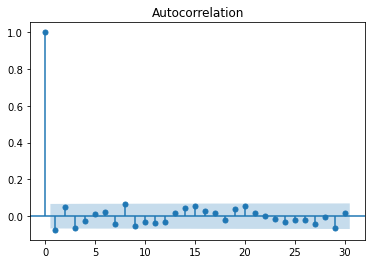

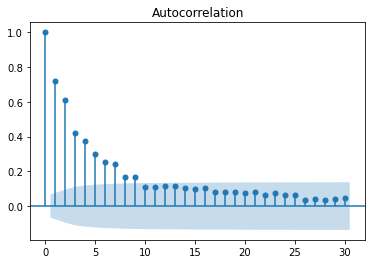

In [131]:
# Plot the autocorrelation of the returns
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sp500['Log Return'].dropna())
plt.show()

# Now, plot the autocorrelation of squared returns

plot_acf(sp500['Squared Return'].dropna())
plt.show()


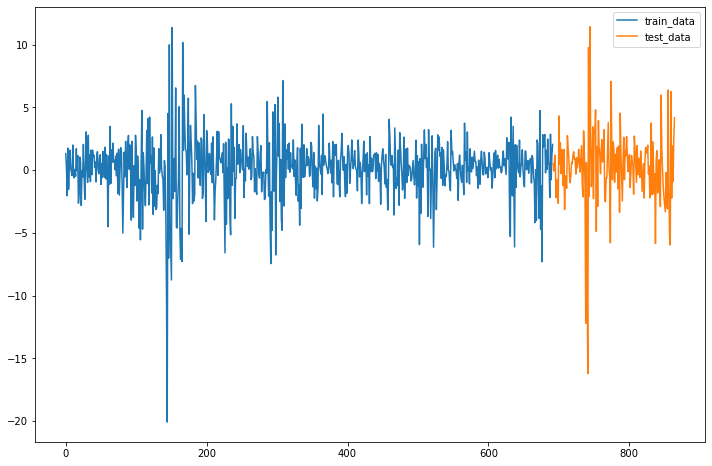

In [132]:

# Split the data into 80% train and 20% test
split = int(len(sp500_returns) * 0.8)
train, test = sp500_returns[:split], sp500_returns[split:]

# Plot the train_data, val_data and test_data sets
plt.figure(figsize=(12, 8))
plt.plot(train['Log Return'], label='train_data')
plt.plot(test['Log Return'], label='test_data')
plt.legend()
plt.show()

In [133]:
# Perform an ADF test on the data
adf_result = adfuller(sp500['Log Return'].dropna())

# adf test value and p-value
adf, p_value, *_ = adf_result

# Print out adf and its p-value
print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')

ADF Statistic: -17.736493846642635
p-value: 3.416892870817883e-30


### VIsualizing low frequency data

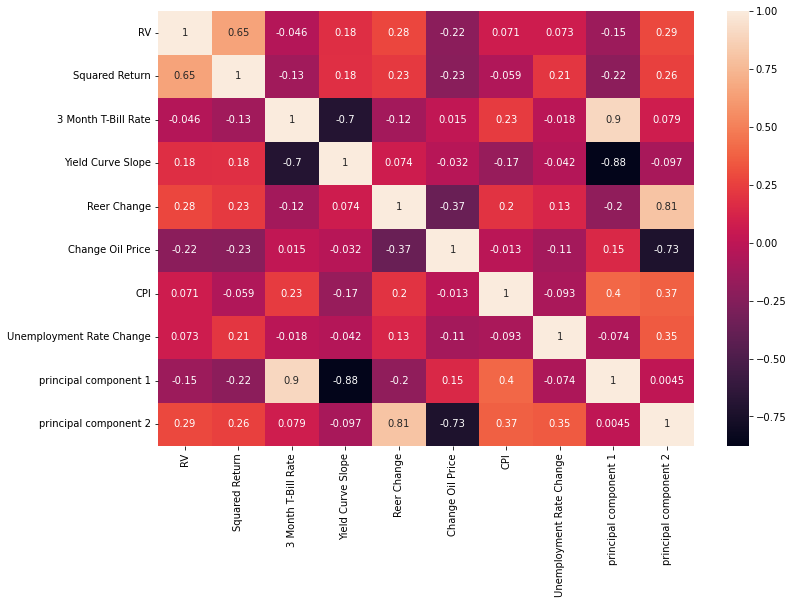

In [134]:
visualization_df = merged_df[features + ['principal component 1', 'principal component 2', 'YearMonth', 'RV', 'Squared Return']]

# Take only one row of each YearMonth
visualization_df = visualization_df.groupby('YearMonth').first()

# Visualize the correlation, make RV the first column row
visualization_df = visualization_df[['RV', 'Squared Return'] + features + ['principal component 1', 'principal component 2']]
visualization_df

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(visualization_df.corr(), annot=True)
plt.show()

### GARCH Models


train_data = sp500[:int(len(sp500)*0.6)]
val_data = sp500[int(len(sp500)*0.6):int(len(sp500)*0.8)]
test_data = sp500[int(len(sp500)*0.8):]


In [135]:
return_data = sp500['Log Return']
volatility_data = sp500['Squared Return']
return_data

0      1.303720
1      0.167896
2     -2.049422
3      1.746854
4     -1.545704
         ...   
860   -2.233753
861    1.917278
862   -0.933206
863    2.517005
864    4.169210
Name: Log Return, Length: 865, dtype: float64

In [136]:
# Create a GARCH(1, 1) model, first train it on train data, then test on test data

garch11_model = arch_model(return_data, p=1, q=1)
garch11_model_fit = garch11_model.fit()
garch11_model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 173263483211.48572
Iteration:      2,   Func. Count:     14,   Neg. LLF: 344135.46550116816
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1908.6362256067978
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1859.334591497315
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1859.8197768254613
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2209.968982977458
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1857.5829748515562
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1857.5554689417058
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1857.5428705300483
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1857.5425798489268
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1857.542575248399
Iteration:     12,   Func. Count:     68,   Neg. LLF: 1857.542575248348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1857.542575248399
            Iteratio

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1857.54
Distribution:                  Normal   AIC:                           3723.09
Method:            Maximum Likelihood   BIC:                           3742.14
                                        No. Observations:                  865
Date:                Mon, Nov 06 2023   Df Residuals:                      864
Time:                        16:48:46   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3020  5.855e-02      5.159  2.488e-07 [  0.187,  0.417]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4096      0.117      3.498  4.690e-04 [  0.180,  0.639]
alpha[1]       0.3240  6.865e-02      4.720  2.359e-06 [  0.189,  0.459]
beta[1]        0.6422  5.158e-02     12.451  1.378e-35 [  0.541,  0.743]
========================================================================

Covariance estimator: robust
"""

In [137]:
rolling_predictions = []
test_size = 730

for i in range(test_size):
    train = return_data[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [138]:
rolling_predictions = pd.Series(rolling_predictions, index=return_data.index[-730:])

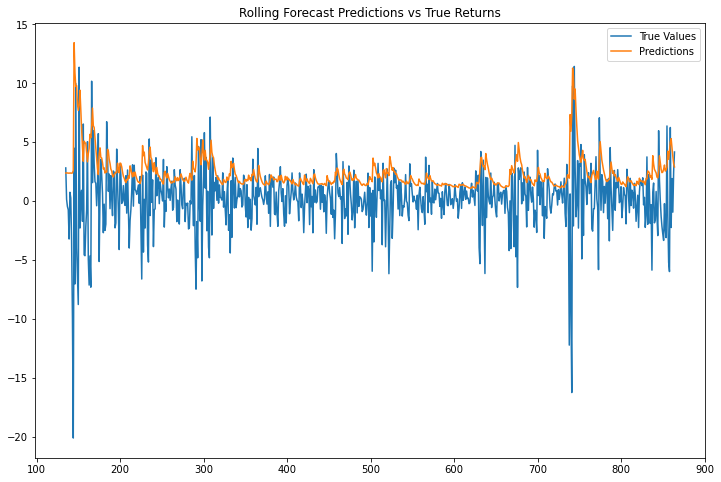

In [139]:
plt.figure(figsize=(12,8))
true, = plt.plot(return_data[-730:])
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predictions vs True Returns')
plt.legend(['True Values','Predictions'])

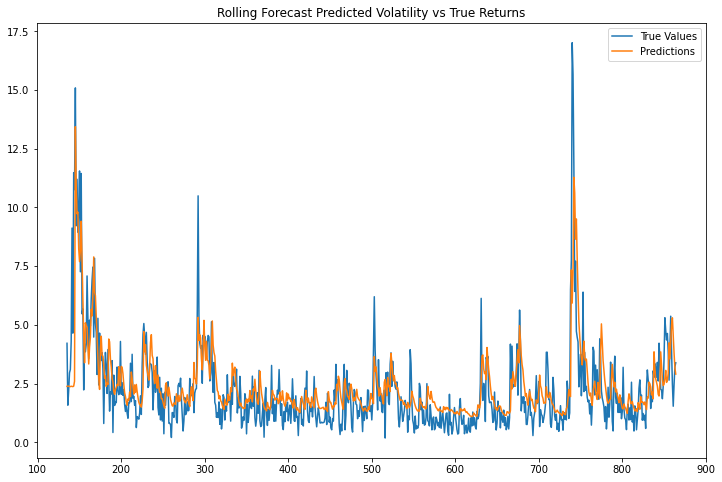

In [140]:
plt.figure(figsize=(12,8))
true, = plt.plot(np.sqrt(volatility_data[-730:]))
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])

### GJR-GARCH Model

In [141]:
# Build a GJR-GARCH(1, 1, 1) model

rolling_predictions = []
test_size = 730

for i in range(test_size):
    train = return_data[:-(test_size-i)]
    model = arch_model(train, p=1, o=1, q=1)
    model_fit = model.fit(disp='off')
    model_fit
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=return_data.index[-730:])

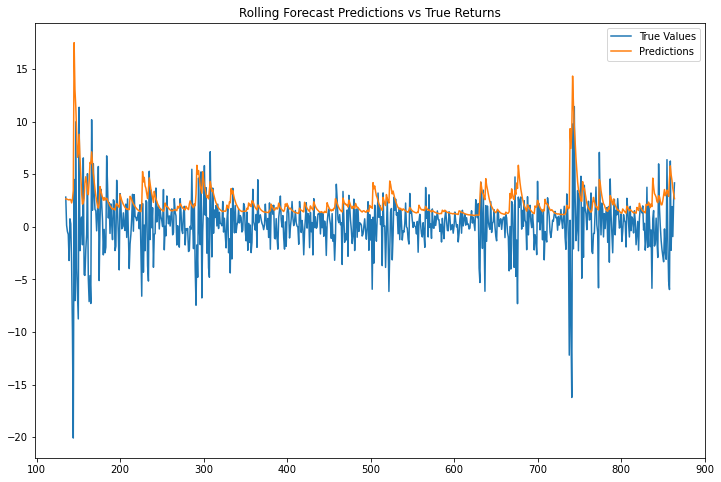

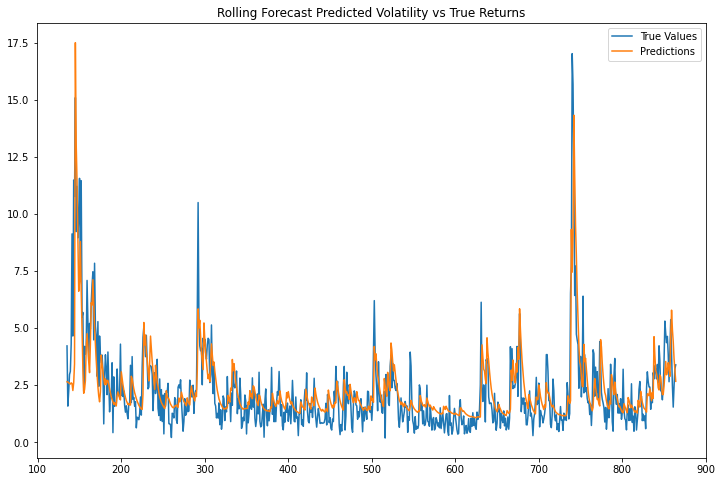

In [142]:
plt.figure(figsize=(12,8))
true, = plt.plot(return_data[-730:])
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predictions vs True Returns')
plt.legend(['True Values','Predictions'])

plt.figure(figsize=(12,8))
true, = plt.plot(np.sqrt(volatility_data[-730:]))
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])


### EGARCH

In [161]:
# Build an EGARCH(1, 1, 1) model

rolling_predictions = []
test_size = 730

for i in range(test_size):
    train = return_data[:-(test_size-i)]
    model = arch_model(train, p=1, q=1, vol='EGARCH')
    model_fit = model.fit(disp='off', options={'maxiter': 20})
    model_fit
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=return_data.index[-730:])

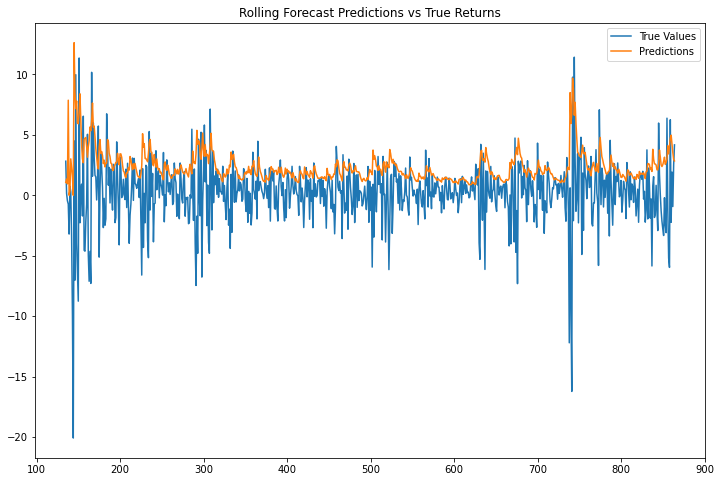

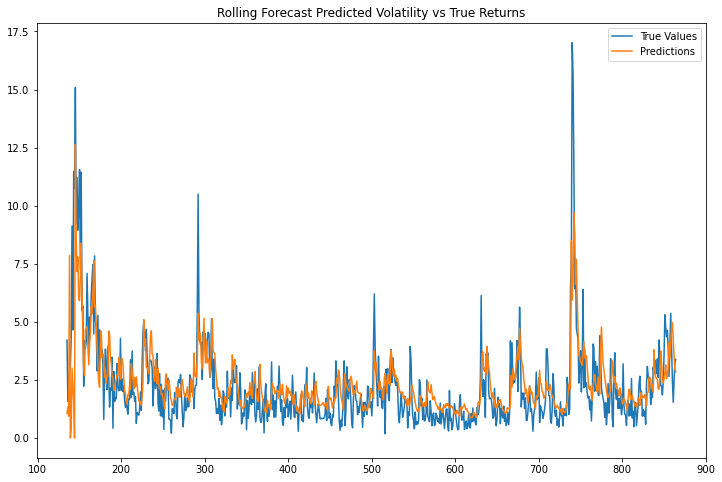

In [159]:
plt.figure(figsize=(12,8))
true, = plt.plot(return_data[-730:])
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predictions vs True Returns')
plt.legend(['True Values','Predictions'])

plt.figure(figsize=(12,8))
true, = plt.plot(np.sqrt(volatility_data[-730:]))
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])


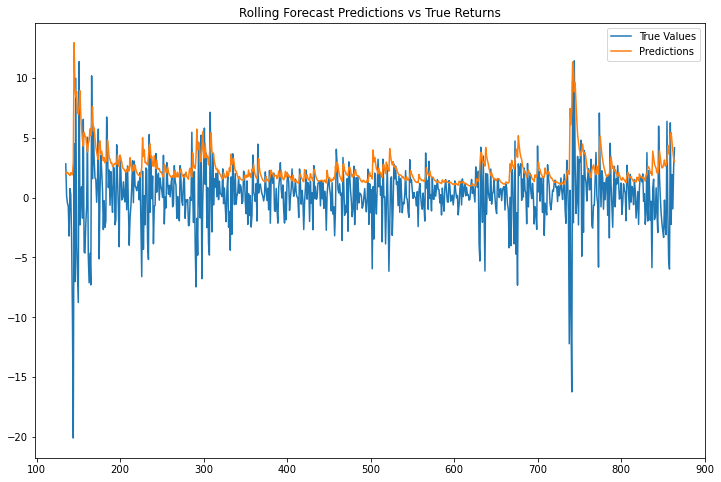

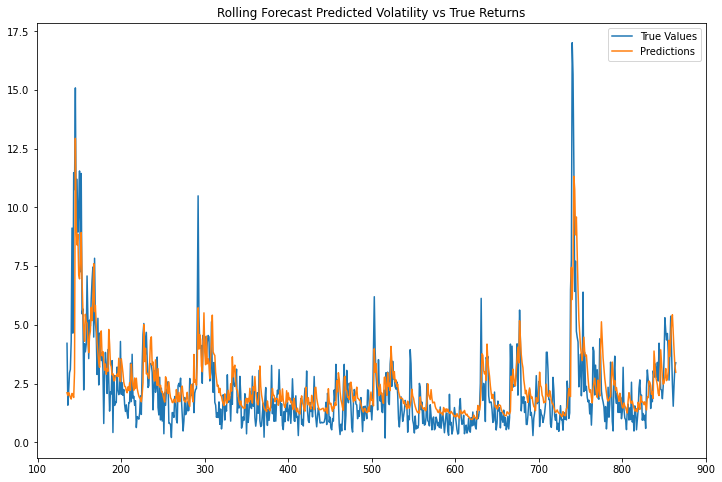

In [162]:
rolling_predictions = []
test_size = 730

for i in range(test_size):
    train = return_data[:-(test_size-i)]
    model = arch_model(train, p=1, q=1, vol='FIGARCH')
    model_fit = model.fit(disp='off')
    model_fit
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=return_data.index[-730:])

plt.figure(figsize=(12,8))
true, = plt.plot(return_data[-730:])
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predictions vs True Returns')
plt.legend(['True Values','Predictions'])

plt.figure(figsize=(12,8))
true, = plt.plot(np.sqrt(volatility_data[-730:]))
preds, = plt.plot(rolling_predictions)
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])


/home/lauri/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/lauri/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/lauri/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/lauri/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/lauri/anaconda3/lib/python3.9/site-packages/arch/u

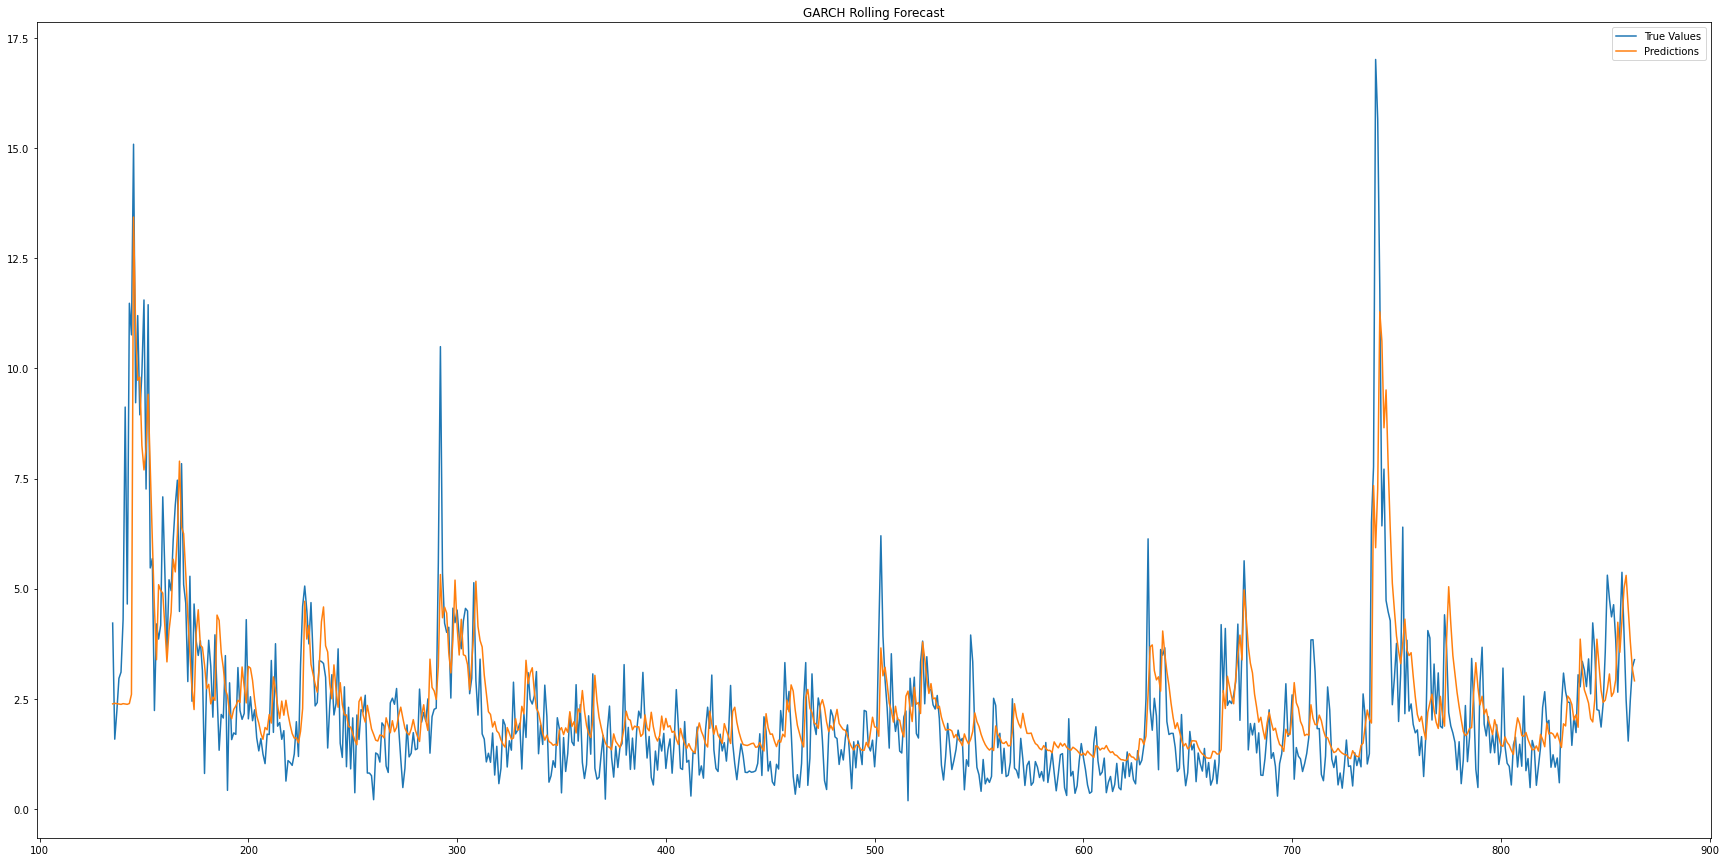

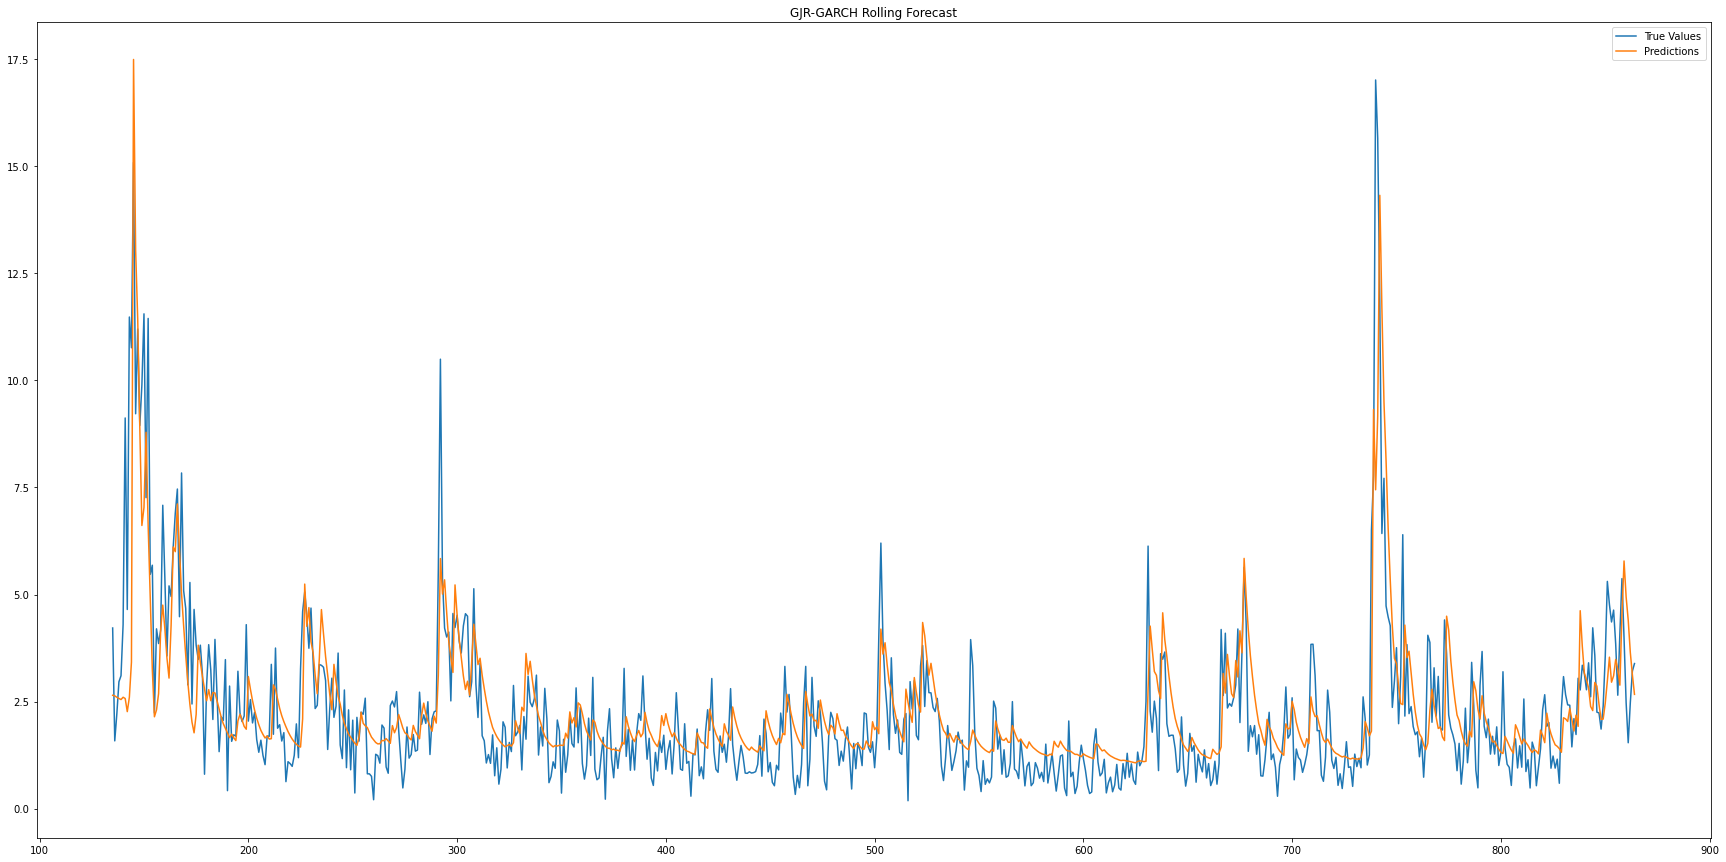

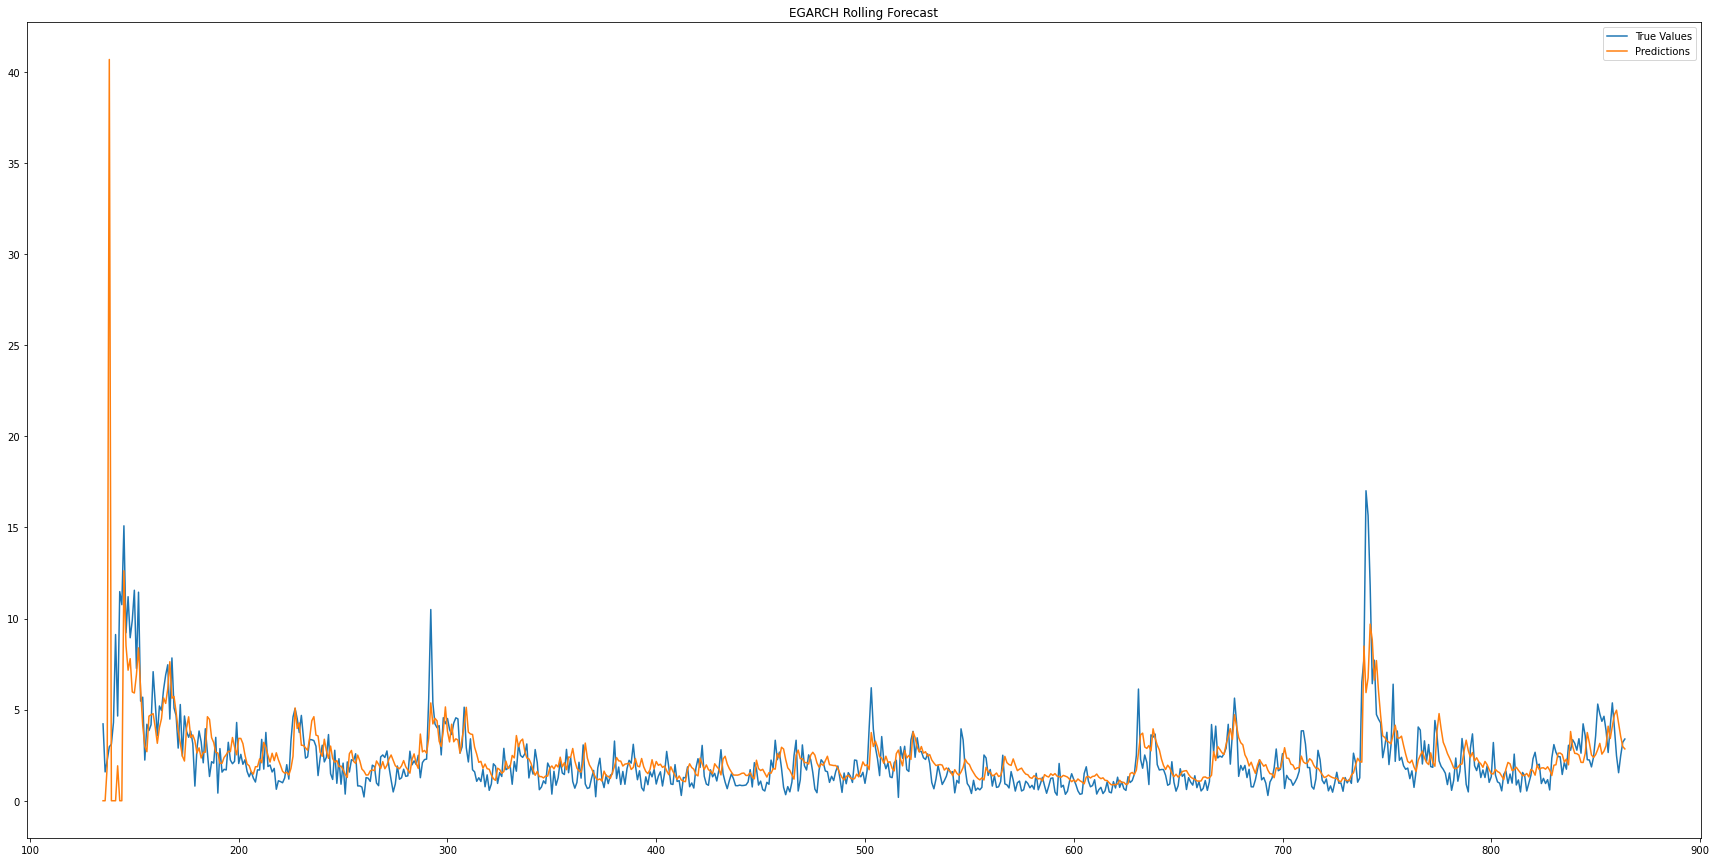

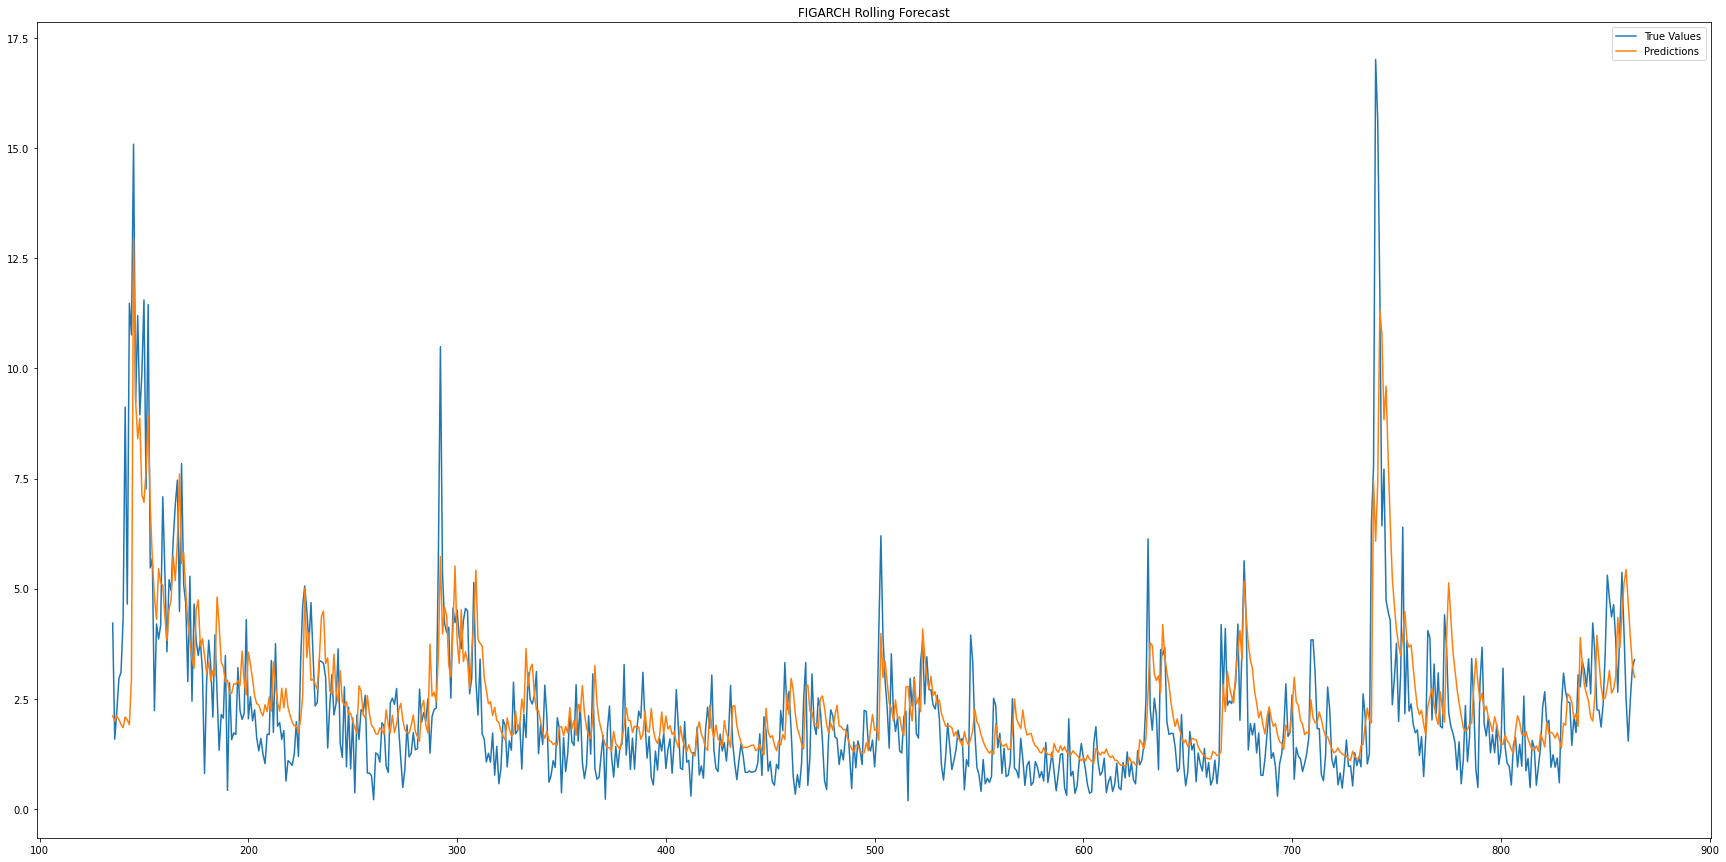

In [169]:
# Define a function to perform rolling forecast with different GARCH models
def rolling_garch_forecast(data, test_size, garch_type='GARCH', p=1, o=0, q=1):
    rolling_predictions = []
    
    for i in range(test_size):
        train = data[:-(test_size-i)]
        if garch_type == 'GARCH':
            model = arch_model(train, p=p, q=q)
        elif garch_type == 'GJR-GARCH':
            model = arch_model(train, p=p, o=1, q=q)
        elif garch_type == 'EGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='EGARCH')
        elif garch_type == 'FIGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='FIGARCH')
        else:
            raise ValueError("Unsupported GARCH model type")
        
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
    rolling_predictions = pd.Series(rolling_predictions, index=data.index[-test_size:])
    return rolling_predictions

# Function to plot the results
def plot_rolling_forecast(true_data, predicted_data, title):
    plt.figure(figsize=(12, 8))
    true, = plt.plot(true_data, label='True Values')
    preds, = plt.plot(predicted_data, label='Predictions')
    plt.title(title)
    plt.legend(handles=[true, preds])
    plt.show()

def plot_volatility(true_data, predicted_data, title):
    plt.figure(figsize=(30, 15))
    true, = plt.plot(np.sqrt(true_data))
    preds, = plt.plot(predicted_data)
    plt.title(title)
    plt.legend(['True Values', 'Predictions'])
    plt.show()

# Example usage:
# Assume return_data is a pandas Series of return data with a datetime index

test_size = 730
garch11_forecast = rolling_garch_forecast(return_data, test_size, 'GARCH')
gjr_garch_predictions = rolling_garch_forecast(return_data, test_size, 'GJR-GARCH')
egarch_predictions = rolling_garch_forecast(return_data, test_size, 'EGARCH')
figarch_predictions = rolling_garch_forecast(return_data, test_size, 'FIGARCH')

# Plotting the results
plot_volatility(volatility_data[-test_size:], garch11_forecast, 'GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], gjr_garch_predictions, 'GJR-GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], egarch_predictions, 'EGARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], figarch_predictions, 'FIGARCH Rolling Forecast')